<a href="https://colab.research.google.com/github/y-lims/DADS7203_ThaiAlphabet_Homework/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Prepare the environment

In [ ]:
# List all NVIDIA GPUs as available in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fe32a59c-bff4-6ba2-130e-b44f4fcb0360)


In [ ]:
import os
import shutil
import itertools
import cv2
from random import sample
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from tensorflow.keras.regularizers import l2


In [ ]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

NumPy 1.25.2

Matplotlib 3.7.1

TensorFlow 2.15.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [ ]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(5678)



















































































# 2. Load the Dataset

In [ ]:
# Step 1: Clone the repository
!git clone https://github.com/y-lims/DADS7203_ThaiAlphabet_Homework.git

# Define the paths to the image folders
base_path = '/content/DADS7203_ThaiAlphabet_Homework'
image_folders = [
    os.path.join(base_path, 'ค'),
    os.path.join(base_path, 'ฅ'),
    os.path.join(base_path, 'ด'),
    os.path.join(base_path, 'ต'),
    os.path.join(base_path, 'ศ')
]

Cloning into 'DADS7203_ThaiAlphabet_Homework'...
remote: Enumerating objects: 1952, done.
remote: Counting objects: 100% (1952/1952), done.
remote: Compressing objects: 100% (1950/1950), done.
remote: Total 1952 (delta 56), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (1952/1952), 4.62 MiB | 10.41 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [ ]:
# Initialize empty lists to store images and labels
X = []
y = []

# Process each folder
for idx, folder in enumerate(image_folders):
    print(f"Processing folder: {folder}")

    # List all files in the folder and label class
    images = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

    # Load each image in the folder
    for image_name in images:
        image_path = os.path.join(folder, image_name)

        # Use PIL to open and resize the image
        try:
            image = Image.open(image_path).convert('RGB')  # Convert to RGB if necessary
            image = image.resize((224, 224))  # Resize image to 224x224
            X.append(np.array(image))
            y.append(idx)  # Use the folder index as the label
        except Exception as e:
            print(f"Skipping image {image_name} due to error: {str(e)}")

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Processing folder: /content/DADS7203_ThaiAlphabet_Homework/ค
Processing folder: /content/DADS7203_ThaiAlphabet_Homework/ฅ
Processing folder: /content/DADS7203_ThaiAlphabet_Homework/ด
Processing folder: /content/DADS7203_ThaiAlphabet_Homework/ต
Processing folder: /content/DADS7203_ThaiAlphabet_Homework/ศ
X shape: (1852, 224, 224, 3)
y shape: (1852,)


# 3. Prepare our dataset to match with ResNet50

In [ ]:
# Define the input shape based on your image size (e.g., 32x32 pixels)
img_w, img_h = 224, 224

# Load ResNet50 with ImageNet weights, excluding the top (classification) layers
ResNet50_extractor = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_w, img_h, 3))

# Print the summary of the ResNet50 model
ResNet50_extractor.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [ ]:
# Preprocess input images for ResNet50
X_ResNet50 = tf.keras.applications.resnet50.preprocess_input(X)

# Split dataset into training and testing sets
X_train, x_test, Y_train, y_test = train_test_split(X_ResNet50, y, test_size=0.2, random_state=42)

# Inspect the dataset
print( f"X_train: type={type(X_train)} , dtype={X_train.dtype} , shape={X_train.shape} , min={X_train.min(axis=None)} , max={X_train.max(axis=None)}" )
print( f"y_train: type={type(Y_train)} , dtype={Y_train.dtype} , shape={Y_train.shape} , min={min(Y_train)} , max={max(Y_train)}" )
print( f"x_test: type={type(x_test)} , dtype={x_test.dtype} , shape={x_test.shape} , min={x_test.min(axis=None)} , max={x_test.max(axis=None)}"  )
print( f"y_test: type={type(y_test)} , dtype={y_test.dtype} , shape={y_test.shape} , min={min(y_test)} , max={max(y_test)}" )

X_train: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(1481, 224, 224, 3) , min=-123.68000030517578 , max=151.06100463867188
y_train: type=<class 'numpy.ndarray'> , dtype=int64 , shape=(1481,) , min=0 , max=4
x_test: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(371, 224, 224, 3) , min=-123.68000030517578 , max=151.06100463867188
y_test: type=<class 'numpy.ndarray'> , dtype=int64 , shape=(371,) , min=0 , max=4


In [ ]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
])

# Function to apply augmentation to each class
def augment_images(images, labels, augmentation):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        img = augmentation(tf.expand_dims(img, 0))
        augmented_images.append(img[0])
        augmented_labels.append(label)
    return np.array(augmented_images), np.array(augmented_labels)

# Augment training data for each class separately
x_train_augmented, y_train_augmented = augment_images(X_train, Y_train, data_augmentation)

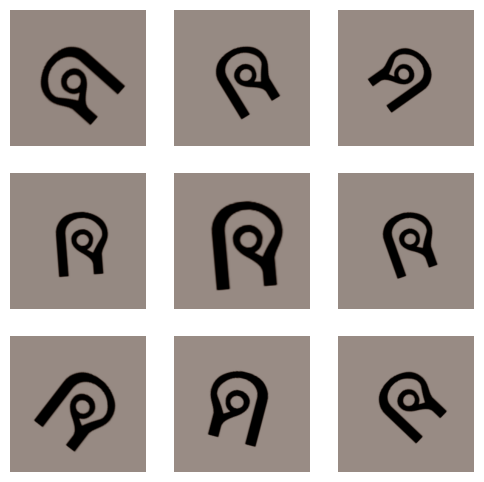

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(9):
    augmented_image = data_augmentation(X_train[:5])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

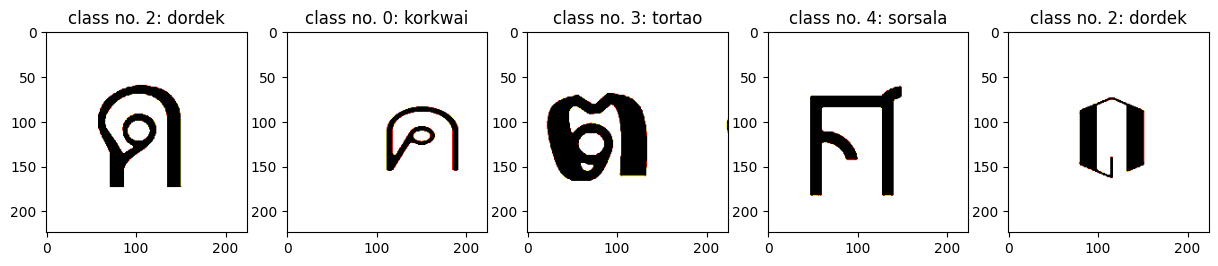

In [ ]:
# Show data without Augmentation
collected_labels = ['korkwai', 'korkon', 'dordek', 'tortao', 'sorsala']

plt.figure(figsize=(15, 5))
for i in range(5):
    class_index = Y_train[i]
    class_label = collected_labels[class_index]

    plt.subplot(150 + 1 + i).set_title(f"class no. {class_index}: {class_label}")
    plt.imshow(X_train[i])
plt.show()

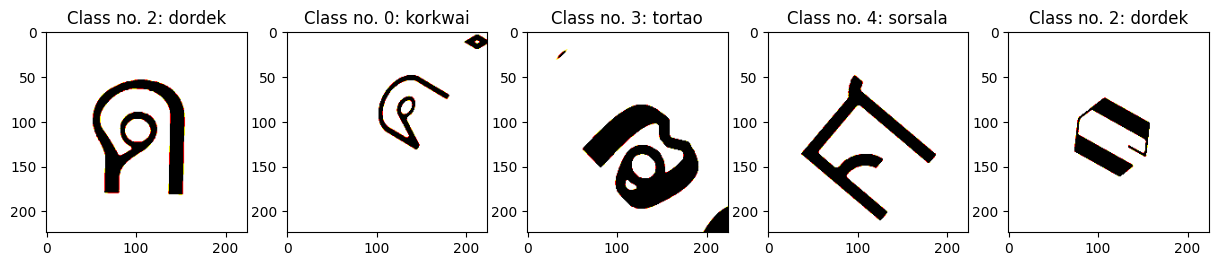

In [ ]:
# Show the data with Augmentation
collected_labels = ['korkwai', 'korkon', 'dordek', 'tortao', 'sorsala']

# Plotting augmented images with their class labels
plt.figure(figsize=(15, 5))
for i in range(5):  # Plot first 5 augmented images
    class_index = y_train_augmented[i]
    class_label = collected_labels[class_index]

    plt.subplot(150 + 1 + i).set_title(f"Class no. {class_index}: {class_label}")
    plt.imshow(x_train_augmented[i])
plt.show()

## EDA

In [ ]:
# Concatenate original and augmented data
x_train = np.concatenate([X_train, x_train_augmented], axis=0)
y_train = np.concatenate([Y_train, y_train_augmented], axis=0)

# Inspect the dataset
print( f"X_train: type={type(x_train)} , dtype={x_train.dtype} , shape={x_train.shape} , min={x_train.min(axis=None)} , max={x_train.max(axis=None)}" )
print( f"y_train: type={type(y_train)} , dtype={y_train.dtype} , shape={y_train.shape} , min={min(y_train)} , max={max(y_train)}" )
print( f"x_test: type={type(x_test)} , dtype={x_test.dtype} , shape={x_test.shape} , min={x_test.min(axis=None)} , max={x_test.max(axis=None)}"  )
print( f"y_test: type={type(y_test)} , dtype={y_test.dtype} , shape={y_test.shape} , min={min(y_test)} , max={max(y_test)}" )

X_train: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(2962, 224, 224, 3) , min=-123.68000030517578 , max=160.4251708984375
y_train: type=<class 'numpy.ndarray'> , dtype=int64 , shape=(2962,) , min=0 , max=4
x_test: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(371, 224, 224, 3) , min=-123.68000030517578 , max=151.06100463867188
y_test: type=<class 'numpy.ndarray'> , dtype=int64 , shape=(371,) , min=0 , max=4


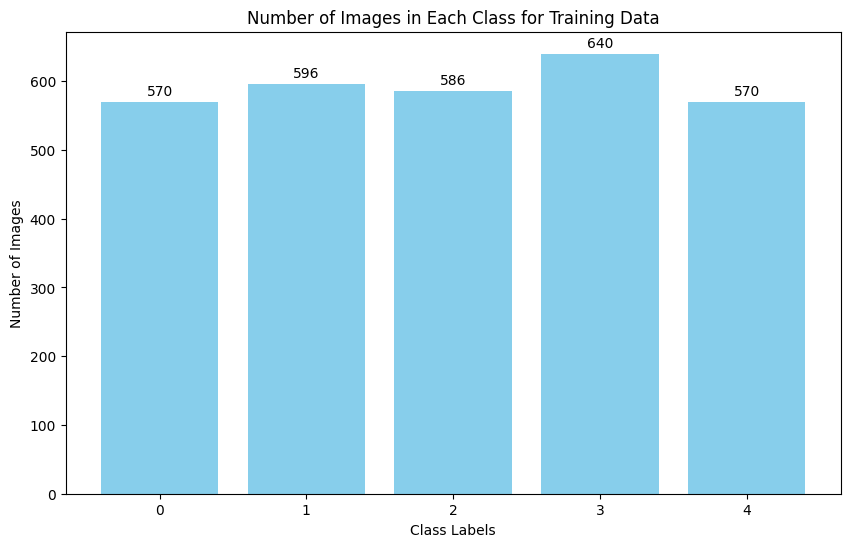

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example y_train and x_train data
y_train_plot = np.random.randint(0, 5, size=2962)  # Replace with your actual y_train data
x_train_plot = np.random.rand(2962, 128, 128)  # Replace with your actual x_train data

# Collected labels (assuming labels are from 0 to 4)
collected_labels = range(5)

# Count the number of images in each class
class_counts = [np.sum(y_train_plot == i) for i in range(len(collected_labels))]

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(collected_labels, class_counts, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class for Training Data')

# Add data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

plt.show()


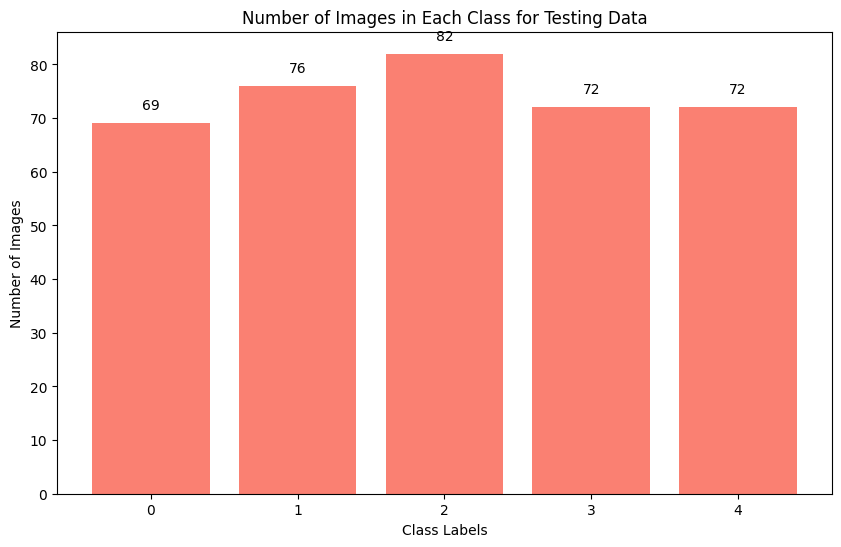

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example y_test and x_test data
y_test_plot = np.random.randint(0, 5, size=371)  # Replace with your actual y_test data
x_test_plot = np.random.rand(371, 224, 224)  # Replace with your actual x_test data

# Collected labels (assuming labels are from 0 to 4)
collected_labels = range(5)

# Count the number of images in each class
class_counts = [np.sum(y_test_plot == i) for i in range(len(collected_labels))]

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(collected_labels, class_counts, color='salmon')
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class for Testing Data')

# Add data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, int(yval), ha='center', va='bottom')

plt.show()


### Resize Images

In [ ]:
# Preprocess input images for ResNet50
x_train_ResNet50 = tf.keras.applications.resnet50.preprocess_input(x_train)
x_test_ResNet50 = tf.keras.applications.resnet50.preprocess_input(x_test)

# # Default
# x_train_ResNet50 = tf.keras.applications.resnet50.preprocess_input(X_train)
# x_test_ResNet50 = tf.keras.applications.resnet50.preprocess_input(x_test)

# Check the properties of the preprocessed data
print(x_train_ResNet50.dtype, x_train_ResNet50.shape, np.min(x_train_ResNet50), np.max(x_train_ResNet50))
print(x_test_ResNet50.dtype, x_test_ResNet50.shape, np.min(x_test_ResNet50), np.max(x_test_ResNet50))


float32 (2962, 224, 224, 3) -233.558 36.745796
float32 (371, 224, 224, 3) -233.558 27.381004


# 4. Prepare for transfer learning and finetuning

1. Add the new classification head
2. Decide whether to freeze or unfreeze any pretrained layers

## 4.1 Access and freeze layer(s) in Keras's model

In [ ]:
# Load ResNet50 with pre-trained weights from ImageNet, excluding the top (classification) layer
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
# base_model.trainable = False

# Unfreeze last n layers
num_layers_to_unfreeze = 3
for layer in base_model.layers[:-num_layers_to_unfreeze]:
    layer.trainable = False

In [ ]:
# Iterate over all layers in the model and print their names and trainable status
for i, layer in enumerate(base_model.layers):
    print(f"Layer {i}: name = {layer.name}, Trainable = {layer.trainable}")

Layer 0: name = input_2, Trainable = False
Layer 1: name = conv1_pad, Trainable = False
Layer 2: name = conv1_conv, Trainable = False
Layer 3: name = conv1_bn, Trainable = False
Layer 4: name = conv1_relu, Trainable = False
Layer 5: name = pool1_pad, Trainable = False
Layer 6: name = pool1_pool, Trainable = False
Layer 7: name = conv2_block1_1_conv, Trainable = False
Layer 8: name = conv2_block1_1_bn, Trainable = False
Layer 9: name = conv2_block1_1_relu, Trainable = False
Layer 10: name = conv2_block1_2_conv, Trainable = False
Layer 11: name = conv2_block1_2_bn, Trainable = False
Layer 12: name = conv2_block1_2_relu, Trainable = False
Layer 13: name = conv2_block1_0_conv, Trainable = False
Layer 14: name = conv2_block1_3_conv, Trainable = False
Layer 15: name = conv2_block1_0_bn, Trainable = False
Layer 16: name = conv2_block1_3_bn, Trainable = False
Layer 17: name = conv2_block1_add, Trainable = False
Layer 18: name = conv2_block1_out, Trainable = False
Layer 19: name = conv2_block2_

## 4.2 Add a new classification head

In [ ]:
# Assuming base_model is already defined and loaded
num_classes = len(np.unique(y_train))
# num_classes = len(np.unique(Y_train))

# Add your own classification layers on top with regularization
x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
# new_outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Create the full model
model = tf.keras.models.Model(inputs=base_model.input, outputs=new_outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Default
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

# 5. Train the model with transfer learning

No finetuning is done in this example as all pretrained layers are freezed and only newly added layers are trained.

In [ ]:
# Define a callback to save the best model
checkpoint_path = "best_model.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,  # Save only the best model (overrides previous best)
    mode='max',  # Save the model with maximum validation accuracy
    verbose=1  # Print messages about saving model
)

In [ ]:
# # Default
# history = model.fit(x_train_ResNet50, Y_train,
#                     batch_size=32,
#                     epochs=20,
#                     verbose=1,
#                     validation_split=0.3,
#                     callbacks=[checkpoint_callback])

In [ ]:
history = model.fit(x_train_ResNet50, y_train,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    validation_split=0.3,
                    callbacks=[checkpoint_callback])

Epoch 1/20
65/65 [==============================] - ETA: 0s - loss: 8.9780 - accuracy: 0.3353
Epoch 1: val_accuracy improved from -inf to 0.31946, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


65/65 [==============================] - 28s 280ms/step - loss: 8.9780 - accuracy: 0.3353 - val_loss: 2.2093 - val_accuracy: 0.3195
Epoch 2/20
65/65 [==============================] - ETA: 0s - loss: 1.9718 - accuracy: 0.4327
Epoch 2: val_accuracy improved from 0.31946 to 0.44994, saving model to best_model.h5
65/65 [==============================] - 11s 171ms/step - loss: 1.9718 - accuracy: 0.4327 - val_loss: 1.9846 - val_accuracy: 0.4499
Epoch 3/20
65/65 [==============================] - ETA: 0s - loss: 1.7688 - accuracy: 0.4872
Epoch 3: val_accuracy improved from 0.44994 to 0.50394, saving model to best_model.h5


In [ ]:
# when train model finished then unlock setseed and run model at less 3 round for collect the weight of model the is the best score
# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
# After training, load the best model from the checkpoint file
best_model = tf.keras.models.load_model(checkpoint_path)
print(f"Successfully loaded best model from '{checkpoint_path}'")

# 6. Grad-CAM for CNN

In [ ]:
n = 5  # Number of images to visualize
samples = x_test[:n]
y_pred = model.predict(samples)

def compute_gradcam(model, img_array, layer_name, class_index):
    """
    Compute Grad-CAM for a specific class index in an image array.

    Args:
    - model: The pre-trained model (after training).
    - img_array: The preprocessed input image.
    - layer_name: The name of the last convolutional layer.
    - class_index: The index of the class for which Grad-CAM should be computed.

    Returns:
    - The heatmap image overlaid on the original image.
    """
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    # Compute gradients with respect to the last convolutional layer
    grads = tape.gradient(loss, conv_outputs)[0]

    # Global average pooling to get the weights of the neurons
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by its weight
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize heatmap to the size of the original image
    heatmap = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[2]))
    heatmap = np.uint8(255 * heatmap)

    # Convert heatmap to RGB
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap on original image
    superimposed_img = cv2.addWeighted(np.uint8(255 * img_array[0]), 0.6, heatmap, 0.4, 0)

    return superimposed_img

In [ ]:
def visualize_gradcam(model, img_array, true_label, predicted_label, class_index, layer_name):
    """
    Visualize Grad-CAM heatmap for a specific image and class index.

    Args:
    - model: The pre-trained model (after training).
    - img_array: The preprocessed input image array.
    - true_label: The true label of the image.
    - predicted_label: The predicted label of the image.
    - class_index: The index of the class for which Grad-CAM should be computed.
    - layer_name: The name of the last convolutional layer.
    """
    heatmap = compute_gradcam(model, img_array, layer_name, class_index)

    # Plotting
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(np.uint8(255 * img_array[0]))
    plt.title(f"True label: {true_label}, Predicted label: {predicted_label}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.title('Grad-CAM')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
for i in range(n):
    img_array = np.expand_dims(samples[i], axis=0)
    true_label = y_test[i]
    predicted_label = np.argmax(y_pred[i])
    class_index = predicted_label  # You can choose the class index to visualize (e.g., predicted_label)
    layer_name = 'conv5_block3_out'  # Name of the last convolutional layer

    visualize_gradcam(model, img_array, true_label, predicted_label, class_index, layer_name)

# 7. Evaluate the model on test set

In [ ]:
results = model.evaluate(x_test_ResNet50, y_test, batch_size=128)
print(f"{model.metrics_names}: {results}")

# Predict on the full test set
y_pred_full = model.predict(x_test_ResNet50)
predicted_labels = np.argmax(y_pred_full, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels, average='weighted')
recall = recall_score(y_test, predicted_labels, average='weighted')
f1 = f1_score(y_test, predicted_labels, average='weighted')

# Print results
print("Confusion Matrix:")
print(cm)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(collected_labels))
plt.xticks(tick_marks, collected_labels, rotation=45)
plt.yticks(tick_marks, collected_labels)

# Add labels to the confusion matrix plot
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# 8. Inference

In [ ]:
plt.rcParams["axes.linewidth"] = 5
def color_frame(ax, y_true, y_pred):
    # Green frame means correct prediction. Red frame means incorrect prediction.
    color = 'green' if (y_true == y_pred) else 'red'
    ax.spines['bottom'].set_color(color)
    ax.spines['top'].set_color(color)
    ax.spines['right'].set_color(color)
    ax.spines['left'].set_color(color)

In [ ]:
# Assuming x_test_ResNet50, y_test, collected_labels, and model are already defined and loaded

# Number of samples to test
n = 5
samples = x_test_ResNet50[:n]
print(f'{samples.shape=}')

# Predict a batch of samples
y_pred = model.predict(samples)

# Interpret the results
for i in range(n):
    print(f"Processing sample {i+1}/{n}")

    # Ensure correct indexing and visualization
    plt.figure(figsize=(3, 3), dpi=90)
    ax = plt.gca()
    plt.imshow(samples[i])  # Display the sample from x_test_ResNet50
    plt.title(f"Sample {i}: true={y_test[i]}({collected_labels[y_test[i]]}), pred={np.argmax(y_pred[i])}({collected_labels[np.argmax(y_pred[i])]})")
    color_frame(ax, y_test[i], np.argmax(y_pred[i]))
    plt.show()